In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import itertools
import pandas as pd
import random


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

# Define the project directory containing zip files
project_dir = '/content/drive/MyDrive/IU/dl_project/project'

# List all zip files in the directory
zip_files = [f for f in os.listdir(project_dir) if f.endswith('.zip')]

# Destination folder for extraction
extract_to = '/content'

# Create destination folder if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract each zip file
for zip_file in zip_files:
    zip_path = os.path.join(project_dir, zip_file)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted: {zip_file}")


Extracted: Testing.zip
Extracted: Training.zip


In [4]:
class FERDataset(Dataset):
    def __init__(self, dir_path, img_size=(48, 48)):
        self.img_size = img_size
        self.images = []
        self.labels = []
        self.label_dict = {}
        label_idx = 0
        for label_name in sorted(os.listdir(dir_path)):
            if not label_name.startswith('.'):
                self.label_dict[label_idx] = label_name
                folder = os.path.join(dir_path, label_name)
                for file in os.listdir(folder):
                    if not file.startswith('.'):
                        img_path = os.path.join(folder, file)
                        img = cv2.imread(img_path)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, img_size)
                        img = img.astype('float32') / 255.0
                        self.images.append(img)
                        self.labels.append(label_idx)
                label_idx += 1
        self.images = np.array(self.images)
        self.labels = np.array(self.labels)
        print(f"{len(self.images)} images loaded from {dir_path}")
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = self.images[idx].transpose(2, 0, 1)  # HWC to CHW
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [5]:
train_dataset = FERDataset('Training', img_size=(48,48))
test_dataset = FERDataset('Testing', img_size=(48,48))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

label_dict = train_dataset.label_dict
NUM_CLASSES = len(label_dict)


28273 images loaded from Training
7067 images loaded from Testing


In [6]:
class VGG16Mini(nn.Module):
    def __init__(self, num_classes=6):
        super(VGG16Mini, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 2
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 3
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 4
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 5
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1000, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

model = VGG16Mini(num_classes=NUM_CLASSES).to(device)


In [7]:
from tqdm import tqdm
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
EPOCHS = 40

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct, total = 0, 0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # Update tqdm description with current loss/accuracy
            pbar.set_postfix({
                'loss': f"{running_loss/total:.4f}",
                'acc': f"{100*correct/total:.2f}%"
            })
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/total:.4f}, Accuracy: {100*correct/total:.2f}%")


Epoch 1/40: 100%|██████████| 442/442 [00:26<00:00, 16.86batch/s, loss=1.7619, acc=25.52%]


Epoch [1/40], Loss: 1.7619, Accuracy: 25.52%


Epoch 2/40: 100%|██████████| 442/442 [00:23<00:00, 18.66batch/s, loss=1.7406, acc=25.50%]


Epoch [2/40], Loss: 1.7406, Accuracy: 25.50%


Epoch 3/40: 100%|██████████| 442/442 [00:24<00:00, 18.26batch/s, loss=1.7232, acc=26.62%]


Epoch [3/40], Loss: 1.7232, Accuracy: 26.62%


Epoch 4/40: 100%|██████████| 442/442 [00:24<00:00, 18.08batch/s, loss=1.6595, acc=29.79%]


Epoch [4/40], Loss: 1.6595, Accuracy: 29.79%


Epoch 5/40: 100%|██████████| 442/442 [00:24<00:00, 17.79batch/s, loss=1.5084, acc=37.40%]


Epoch [5/40], Loss: 1.5084, Accuracy: 37.40%


Epoch 6/40: 100%|██████████| 442/442 [00:24<00:00, 17.74batch/s, loss=1.3652, acc=43.97%]


Epoch [6/40], Loss: 1.3652, Accuracy: 43.97%


Epoch 7/40: 100%|██████████| 442/442 [00:24<00:00, 17.86batch/s, loss=1.2687, acc=48.69%]


Epoch [7/40], Loss: 1.2687, Accuracy: 48.69%


Epoch 8/40: 100%|██████████| 442/442 [00:24<00:00, 17.80batch/s, loss=1.1952, acc=52.17%]


Epoch [8/40], Loss: 1.1952, Accuracy: 52.17%


Epoch 9/40: 100%|██████████| 442/442 [00:24<00:00, 17.78batch/s, loss=1.1301, acc=55.22%]


Epoch [9/40], Loss: 1.1301, Accuracy: 55.22%


Epoch 10/40: 100%|██████████| 442/442 [00:24<00:00, 17.78batch/s, loss=1.0705, acc=57.84%]


Epoch [10/40], Loss: 1.0705, Accuracy: 57.84%


Epoch 11/40: 100%|██████████| 442/442 [00:24<00:00, 17.78batch/s, loss=1.0187, acc=60.27%]


Epoch [11/40], Loss: 1.0187, Accuracy: 60.27%


Epoch 12/40: 100%|██████████| 442/442 [00:24<00:00, 17.84batch/s, loss=0.9621, acc=62.67%]


Epoch [12/40], Loss: 0.9621, Accuracy: 62.67%


Epoch 13/40: 100%|██████████| 442/442 [00:24<00:00, 17.76batch/s, loss=0.8980, acc=65.76%]


Epoch [13/40], Loss: 0.8980, Accuracy: 65.76%


Epoch 14/40: 100%|██████████| 442/442 [00:24<00:00, 17.75batch/s, loss=0.8274, acc=68.33%]


Epoch [14/40], Loss: 0.8274, Accuracy: 68.33%


Epoch 15/40: 100%|██████████| 442/442 [00:24<00:00, 17.76batch/s, loss=0.7630, acc=71.50%]


Epoch [15/40], Loss: 0.7630, Accuracy: 71.50%


Epoch 16/40: 100%|██████████| 442/442 [00:24<00:00, 17.78batch/s, loss=0.6889, acc=74.39%]


Epoch [16/40], Loss: 0.6889, Accuracy: 74.39%


Epoch 17/40: 100%|██████████| 442/442 [00:24<00:00, 17.78batch/s, loss=0.6147, acc=77.13%]


Epoch [17/40], Loss: 0.6147, Accuracy: 77.13%


Epoch 18/40: 100%|██████████| 442/442 [00:24<00:00, 17.74batch/s, loss=0.5382, acc=80.08%]


Epoch [18/40], Loss: 0.5382, Accuracy: 80.08%


Epoch 19/40: 100%|██████████| 442/442 [00:24<00:00, 17.77batch/s, loss=0.4634, acc=83.44%]


Epoch [19/40], Loss: 0.4634, Accuracy: 83.44%


Epoch 20/40: 100%|██████████| 442/442 [00:24<00:00, 17.74batch/s, loss=0.3997, acc=85.77%]


Epoch [20/40], Loss: 0.3997, Accuracy: 85.77%


Epoch 21/40: 100%|██████████| 442/442 [00:24<00:00, 17.81batch/s, loss=0.3442, acc=87.80%]


Epoch [21/40], Loss: 0.3442, Accuracy: 87.80%


Epoch 22/40: 100%|██████████| 442/442 [00:24<00:00, 17.80batch/s, loss=0.2959, acc=89.72%]


Epoch [22/40], Loss: 0.2959, Accuracy: 89.72%


Epoch 23/40: 100%|██████████| 442/442 [00:24<00:00, 17.74batch/s, loss=0.2512, acc=91.41%]


Epoch [23/40], Loss: 0.2512, Accuracy: 91.41%


Epoch 24/40: 100%|██████████| 442/442 [00:24<00:00, 17.75batch/s, loss=0.2218, acc=92.56%]


Epoch [24/40], Loss: 0.2218, Accuracy: 92.56%


Epoch 25/40: 100%|██████████| 442/442 [00:24<00:00, 17.73batch/s, loss=0.1898, acc=93.70%]


Epoch [25/40], Loss: 0.1898, Accuracy: 93.70%


Epoch 26/40: 100%|██████████| 442/442 [00:24<00:00, 17.78batch/s, loss=0.1714, acc=94.35%]


Epoch [26/40], Loss: 0.1714, Accuracy: 94.35%


Epoch 27/40: 100%|██████████| 442/442 [00:24<00:00, 17.77batch/s, loss=0.1588, acc=94.85%]


Epoch [27/40], Loss: 0.1588, Accuracy: 94.85%


Epoch 28/40: 100%|██████████| 442/442 [00:24<00:00, 17.73batch/s, loss=0.1386, acc=95.52%]


Epoch [28/40], Loss: 0.1386, Accuracy: 95.52%


Epoch 29/40: 100%|██████████| 442/442 [00:24<00:00, 17.73batch/s, loss=0.1287, acc=95.81%]


Epoch [29/40], Loss: 0.1287, Accuracy: 95.81%


Epoch 30/40: 100%|██████████| 442/442 [00:24<00:00, 17.76batch/s, loss=0.1164, acc=96.19%]


Epoch [30/40], Loss: 0.1164, Accuracy: 96.19%


Epoch 31/40: 100%|██████████| 442/442 [00:24<00:00, 17.76batch/s, loss=0.1099, acc=96.37%]


Epoch [31/40], Loss: 0.1099, Accuracy: 96.37%


Epoch 32/40: 100%|██████████| 442/442 [00:24<00:00, 17.77batch/s, loss=0.1002, acc=96.72%]


Epoch [32/40], Loss: 0.1002, Accuracy: 96.72%


Epoch 33/40: 100%|██████████| 442/442 [00:24<00:00, 17.78batch/s, loss=0.0981, acc=96.88%]


Epoch [33/40], Loss: 0.0981, Accuracy: 96.88%


Epoch 34/40: 100%|██████████| 442/442 [00:24<00:00, 17.75batch/s, loss=0.0917, acc=97.10%]


Epoch [34/40], Loss: 0.0917, Accuracy: 97.10%


Epoch 35/40: 100%|██████████| 442/442 [00:24<00:00, 17.73batch/s, loss=0.0840, acc=97.21%]


Epoch [35/40], Loss: 0.0840, Accuracy: 97.21%


Epoch 36/40: 100%|██████████| 442/442 [00:24<00:00, 17.73batch/s, loss=0.0803, acc=97.39%]


Epoch [36/40], Loss: 0.0803, Accuracy: 97.39%


Epoch 37/40: 100%|██████████| 442/442 [00:24<00:00, 17.71batch/s, loss=0.0774, acc=97.51%]


Epoch [37/40], Loss: 0.0774, Accuracy: 97.51%


Epoch 38/40: 100%|██████████| 442/442 [00:24<00:00, 17.73batch/s, loss=0.0716, acc=97.78%]


Epoch [38/40], Loss: 0.0716, Accuracy: 97.78%


Epoch 39/40: 100%|██████████| 442/442 [00:24<00:00, 17.68batch/s, loss=0.0721, acc=97.76%]


Epoch [39/40], Loss: 0.0721, Accuracy: 97.76%


Epoch 40/40: 100%|██████████| 442/442 [00:25<00:00, 17.66batch/s, loss=0.0701, acc=97.72%]

Epoch [40/40], Loss: 0.0701, Accuracy: 97.72%


Test Accuracy: 0.61


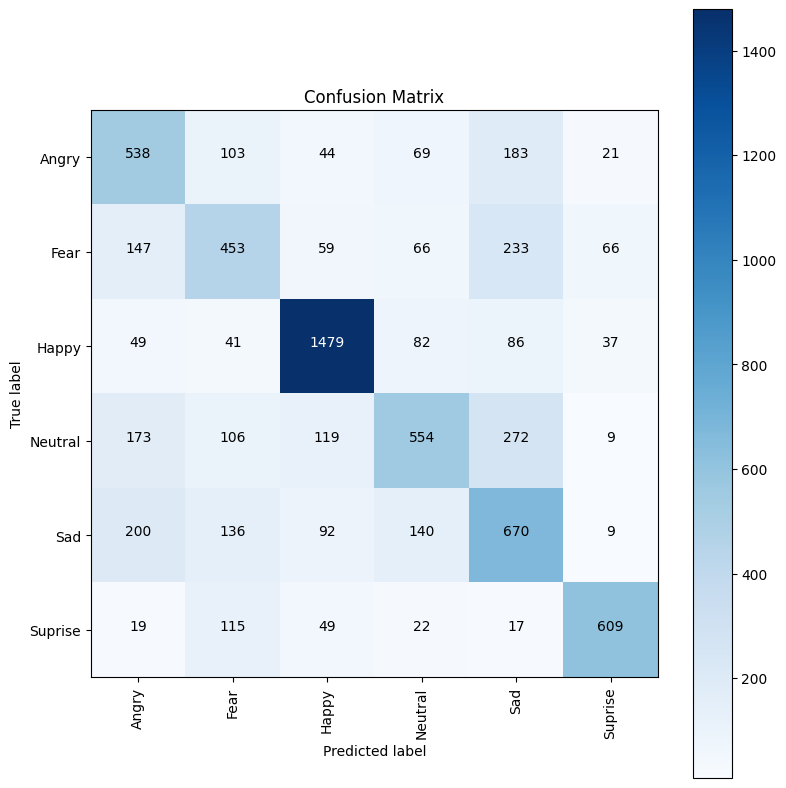

In [8]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.2f}')

cm = confusion_matrix(all_labels, all_preds)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm, [label_dict[i] for i in range(NUM_CLASSES)])


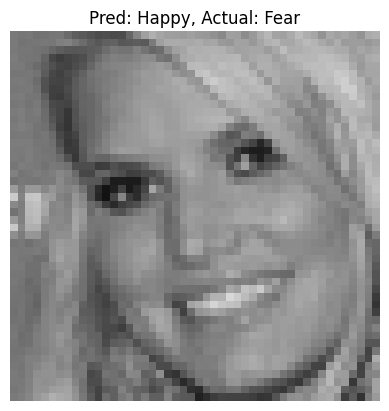

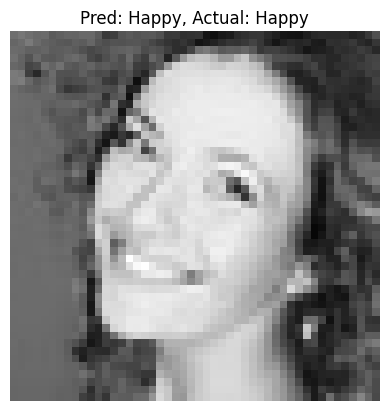

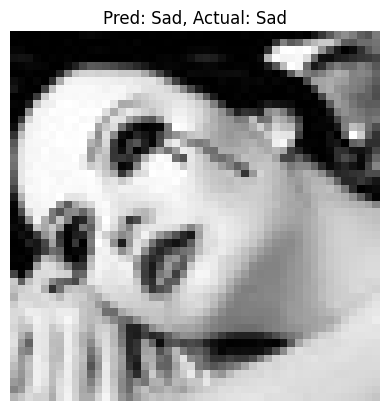

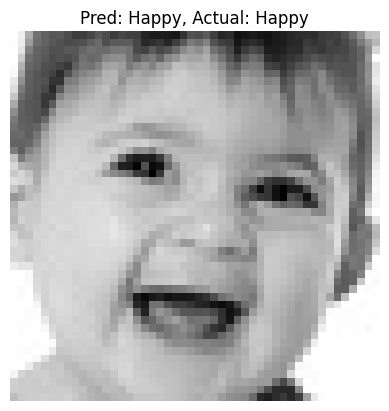

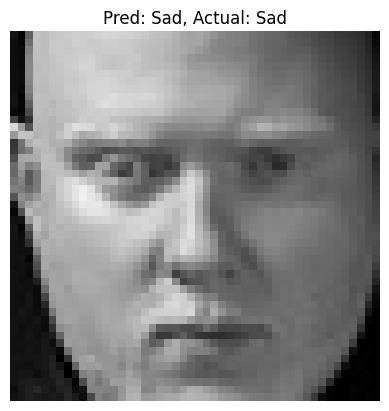

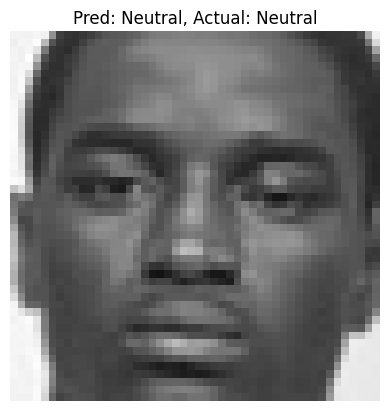

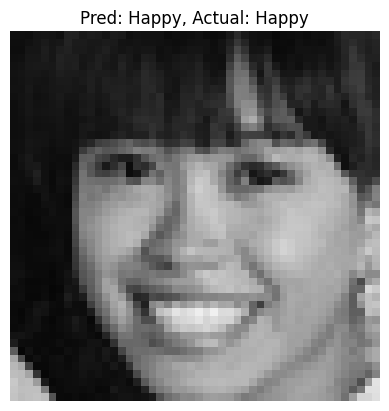

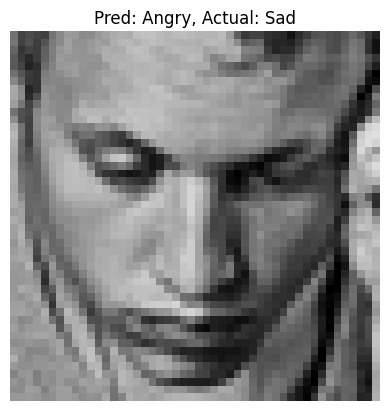

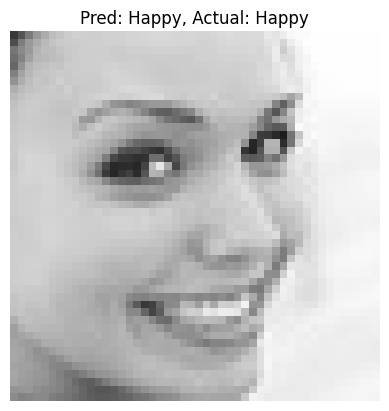

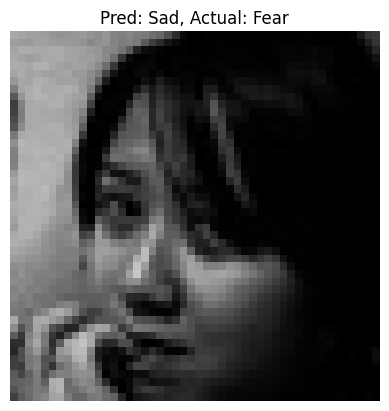

In [10]:
# Show 10 random test predictions
indices = random.sample(range(len(test_dataset)), 10)
for i in indices:
    img, label = test_dataset[i]
    img_disp = img.permute(1,2,0).numpy()
    img_disp = np.clip(img_disp, 0, 1)
    plt.imshow(img_disp)
    # Access the integer value from the 'label' tensor using .item()
    plt.title(f"Pred: {label_dict[all_preds[i]]}, Actual: {label_dict[label.item()]}")
    plt.axis('off')
    plt.show()